In [1]:
#!pip install langgraph
#!pip install llama_index  # or your preferred framework
#!pip install openai       # if we call OpenAI directly or whatever

# Parallel Question Answering with LangGraph

#This notebook demonstrates a powerful workflow for question answering using LangGraph that orchestrates multiple parallel processes to create high-quality, coherent responses. The implementation features both a simulation mode (using mock responses) and a real-world mode with OpenAI integration.

## Architecture Overview

#The workflow implements a sophisticated question processing system with:

#1. **Parallel Execution**: Three simultaneous processes handle different aspects of the question
#2. **Quality Control Loop**: An evaluation feedback mechanism ensures high-quality outputs
#3. **Coherent Synthesis**: All components are combined into a structured final response

## Workflow Components

#- **Orchestrator**: Initiates and coordinates all parallel processes
#- **Question Conversion**: Reformulates the original question in another form
#- **Question Summary**: Creates a concise summary of the core request 
#- **RAG Answer Generation**: Produces detailed, informative answers
#- **Quality Evaluation**: Rates answer quality (0-10) with automatic retry for subpar answers
#- **Synthesizer**: Combines all outputs into a unified response

## Implementation Options

#The notebook includes two complete implementations:

#1. **Simulation Mode**: Uses hardcoded responses for quick testing and development
#2. **LLM Mode**: Integrates with OpenAI GPT-4o for production-quality responses
#3. **RAG not included here just simulated: Rag is not included but simulated (no indexing, etc. done)

## Key Features

#- **Fault Tolerance**: Multiple fallback strategies ensure the system keeps working
#- **Annotated Types**: Proper type definitions for robust state management
#- **Parallel Processing**: Efficient execution through parallel paths
#- **Feedback Loop**: Quality improvement through evaluation-based regeneration

## Usage

# Simulation mode (no API key needed)
#result = chain.invoke({"original_question": "Your question here"})

# LLM mode (requires OpenAI API key)
#answer_question("Your question here")

import os
import getpass
from typing_extensions import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from typing import List
import operator
from IPython.display import Image, display




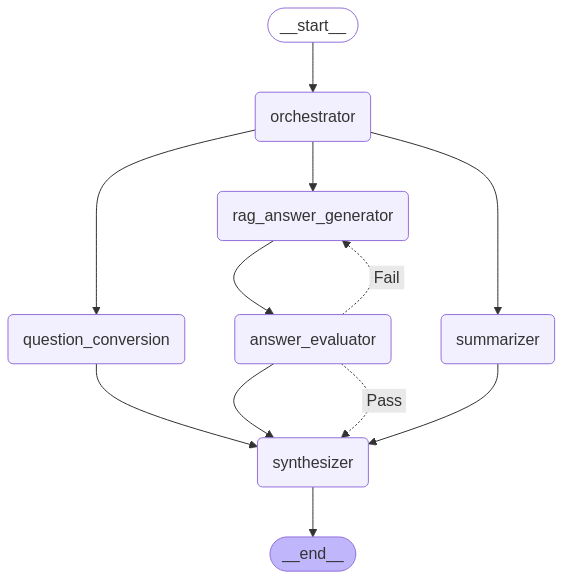

[Orchestrator] Received question: Hvordan kan jeg bake en perfekt sjokoladekake?
[Question Conversion] Converted question: Hvordan lager man en myk og saftig sjokoladekake?
[RAG Answer Generator] RAG answer: For å bake en perfekt sjokoladekake trenger du: 200g mørk sjokolade, 200g smør, 200g sukker, 4 egg, 150g hvetemel, 1 ts bakepulver, og en klype salt. Smelt sjokolade og smør, bland med sukker, egg, og tørre ingredienser. Stek på 175°C i 25-30 minutter.
[Question Summary] Summary: Oppskrift på en saftig sjokoladekake
[Answer Evaluator] Score: 8.0, Attempt: 1, Passed? True
[Synthesizer] Processing history: ['orchestrator', 'question_conversion', 'rag_generator', 'summarizer', 'evaluator']
[Synthesizer] Final Answer:
 **Konvertert spørsmål:** Hvordan lager man en myk og saftig sjokoladekake?
**Oppsummering:** Oppskrift på en saftig sjokoladekake
**Svar:** For å bake en perfekt sjokoladekake trenger du: 200g mørk sjokolade, 200g smør, 200g sukker, 4 egg, 150g hvetemel, 1 ts bakepulver,

In [2]:
#Test without LLM


# Define state with proper annotated types for parallel execution
class WorkflowState(TypedDict):
    # Original question from user (read-only input)
    original_question: str
    # For parallel processes - use reducers to handle multiple updates
    converted_question: str
    question_summary: str
    # For RAG process
    rag_answer: str
    evaluation_passed: bool
    attempt_count: int
    # Final output
    final_answer: str
    # We use a list with the operator.add reducer to track processing
    processed: Annotated[List[str], operator.add]

# For demonstration purposes, simple LLM mock
def call_llm(prompt: str) -> str:
    """
    Minimal placeholder for an LLM call. 
    In a real implementation, you would use OpenAI, LlamaIndex, etc.
    """
    # For testing purposes, return more meaningful mock responses
    if "Konverter følgende spørsmål" in prompt:
        return "Hvordan lager man en myk og saftig sjokoladekake?"
    elif "Oppsummer dette spørsmålet" in prompt:
        return "Oppskrift på en saftig sjokoladekake"
    elif "Basert på tilgjengelig kunnskap" in prompt:
        return "For å bake en perfekt sjokoladekake trenger du: 200g mørk sjokolade, 200g smør, 200g sukker, 4 egg, 150g hvetemel, 1 ts bakepulver, og en klype salt. Smelt sjokolade og smør, bland med sukker, egg, og tørre ingredienser. Stek på 175°C i 25-30 minutter."
    elif "Vurder lesbarhet" in prompt:
        return "8"
    else:
        return f"Svar på: {prompt}"

def orchestrator(state: WorkflowState) -> dict:
    """Initial orchestrator that receives the user question"""
    question = state["original_question"]
    print("[Orchestrator] Received question:", question)
    
    # Return the processed marker
    return {
        "attempt_count": 0,
        "processed": ["orchestrator"]
    }

def question_conversion(state: WorkflowState) -> dict:
    """Converts the question to another form"""
    question = state["original_question"]
    prompt = (
        f"Konverter følgende spørsmål til en annen form: {question}\n"
        "Gjør det kortfattet og presist."
    )
    converted = call_llm(prompt)
    print("[Question Conversion] Converted question:", converted)
    
    return {
        "converted_question": converted,
        "processed": ["question_conversion"]
    }

def question_summary(state: WorkflowState) -> dict:
    """Summarizes the question in one sentence"""
    question = state["original_question"]
    prompt = (
        f"Oppsummer dette spørsmålet i én setning: {question}\n"
        "Fokuser på kjernebudskapet."
    )
    summary = call_llm(prompt)
    print("[Question Summary] Summary:", summary)
    
    return {
        "question_summary": summary,
        "processed": ["summarizer"]
    }

def rag_answer_generator(state: WorkflowState) -> dict:
    """Generates an answer using RAG approach"""
    question = state["original_question"]
    prompt = (
        f"Basert på tilgjengelig kunnskap, gi et svar på dette spørsmålet:\n"
        f"{question}\n"
        "Skriv et kort, men presist svar."
    )
    answer = call_llm(prompt)
    print("[RAG Answer Generator] RAG answer:", answer)
    
    return {
        "rag_answer": answer,
        "processed": ["rag_generator"]
    }

def answer_evaluator(state: WorkflowState) -> dict:
    """Evaluates the answer quality"""
    # Get or initialize attempt counter
    attempt_count = state.get("attempt_count", 0) + 1
    
    # Ask the LLM to score the answer's readability from 0-10
    prompt = (
        "Vurder lesbarhet og kvalitet på dette svaret, gi en poengsum (0-10):\n"
        f"{state['rag_answer']}\n"
        "Gi kun et tall."
    )
    eval_score_str = call_llm(prompt)
    
    # Try to parse a numeric score
    try:
        eval_score = float(eval_score_str)
    except ValueError:
        eval_score = 0.0
    
    # Pass if score >= 5.0 OR we've already tried 3 times (to prevent infinite loops)
    evaluation_passed = (eval_score >= 5.0) or (attempt_count >= 3)
    
    print(f"[Answer Evaluator] Score: {eval_score}, Attempt: {attempt_count}, Passed? {evaluation_passed}")
    
    return {
        "evaluation_passed": evaluation_passed,
        "attempt_count": attempt_count,
        "processed": ["evaluator"]
    }

def synthesizer(state: WorkflowState) -> dict:
    """Combines all components into a final answer"""
    # Get components from state
    converted = state.get("converted_question", "")
    summary = state.get("question_summary", "")
    answer = state.get("rag_answer", "")
    attempts = state.get("attempt_count", 0)
    
    processed = state.get("processed", [])
    print(f"[Synthesizer] Processing history: {processed}")
    
    final_answer = (
        f"**Konvertert spørsmål:** {converted}\n"
        f"**Oppsummering:** {summary}\n"
        f"**Svar:** {answer}\n"
        f"**Antall forsøk:** {attempts}"
    )
    
    print("[Synthesizer] Final Answer:\n", final_answer)
    
    return {
        "final_answer": final_answer,
        "processed": ["synthesizer"]
    }

# Build the workflow
workflow = StateGraph(WorkflowState)

# Add nodes
workflow.add_node("orchestrator", orchestrator)
workflow.add_node("question_conversion", question_conversion)
workflow.add_node("summarizer", question_summary)
workflow.add_node("rag_answer_generator", rag_answer_generator)
workflow.add_node("answer_evaluator", answer_evaluator)
workflow.add_node("synthesizer", synthesizer)

# Edge for orchestrator
workflow.add_edge(START, "orchestrator")

# Use the parallel branching pattern as shown in the documentation
workflow.add_edge("orchestrator", "question_conversion")
workflow.add_edge("orchestrator", "summarizer")
workflow.add_edge("orchestrator", "rag_answer_generator")

# RAG connects to evaluator
workflow.add_edge("rag_answer_generator", "answer_evaluator")

# Conditional edge from evaluator
def check_evaluation(state: WorkflowState) -> str:
    return "Pass" if state.get("evaluation_passed", False) else "Fail"

workflow.add_conditional_edges(
    "answer_evaluator",
    check_evaluation,
    {
        "Pass": "synthesizer",
        "Fail": "rag_answer_generator"  # loop back if it fails
    }
)

# Connect multiple inputs to synthesizer using the recommended fan-in pattern
# This ensures synthesizer only runs when all its inputs are ready
workflow.add_edge(["question_conversion", "summarizer", "answer_evaluator"], "synthesizer")
workflow.add_edge("synthesizer", END)

# Compile - explicitly without checkpointer to avoid config issues
chain = workflow.compile()

# Uncomment to show workflow visualization
display(Image(chain.get_graph().draw_mermaid_png()))

# Initial state
initial_state = {
    "original_question": "Hvordan kan jeg bake en perfekt sjokoladekake?",
    "converted_question": "",
    "question_summary": "",
    "rag_answer": "",
    "evaluation_passed": False,
    "final_answer": "",
    "attempt_count": 0,
    "processed": []
}

# Execute the workflow with recursion limit
try:
    # Try different forms of passing recursion_limit for compatibility
    result_state = chain.invoke(initial_state, {"recursion_limit": 50})
except Exception as e1:
    print(f"First attempt failed: {e1}")
    try:
        result_state = chain.invoke(initial_state, recursion_limit=50)
    except Exception as e2:
        print(f"Second attempt failed: {e2}")
        # Final fallback
        result_state = chain.invoke(initial_state)

print("\n=== FINAL OUTPUT ===")
print(result_state["final_answer"])

Enter your OpenAI API key:  ········


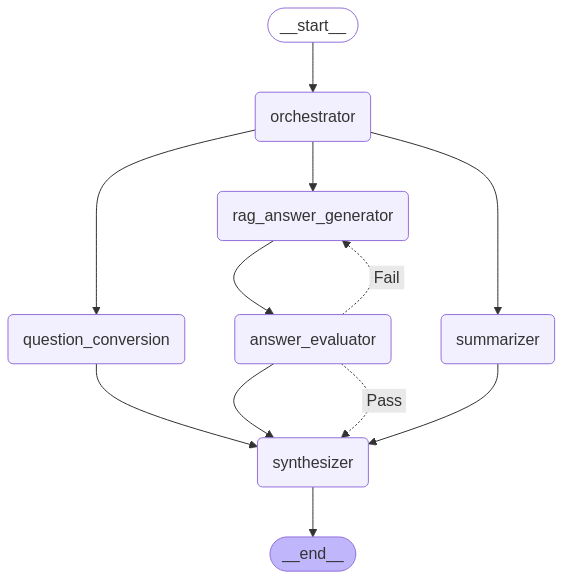

[Orchestrator] Received question: Hvordan kan jeg bake en perfekt sjokoladekake?
[Question Conversion] Converted question: Hva er hemmeligheten bak en perfekt sjokoladekake?
[Question Summary] Summary: Hvordan kan jeg oppnå det beste resultatet når jeg baker en sjokoladekake?
[RAG Answer Generator] RAG answer: For å bake en perfekt sjokoladekake, følg disse trinnene:

1. **Ingredienser**:
   - 200 g hvetemel
   - 200 g sukker
   - 75 g kakaopulver
   - 1,5 ts bakepulver
   - 1,5 ts natron
   - 1 ts salt
   - 2 store egg
   - 240 ml melk
   - 120 ml vegetabilsk olje
   - 2 ts vaniljeekstrakt
   - 240 ml kokende vann

2. **Forberedelse**:
   - Forvarm ovnen til 175°C.
   - Smør og mel en rund kakeform (ca. 23 cm i diameter).

3. **Bland de tørre ingrediensene**:
   - I en stor bolle, sikt sammen mel, sukker, kakao, bakepulver, natron og salt.

4. **Bland de våte ingrediensene**:
   - I en annen bolle, visp sammen egg, melk, olje og vaniljeekstrakt.

5. **Kombiner**:
   - Tilsett de våte 

In [3]:
#With LLM

# LLM and tools
from openai import OpenAI
from llama_index.llms.openai import OpenAI as LlamaOpenAI
from llama_index.core.llms import ChatMessage, MessageRole

# Define state with proper annotated types for parallel execution
class WorkflowState(TypedDict):
    # Original question from user (read-only input)
    original_question: str
    # For parallel processes
    converted_question: str
    question_summary: str
    # For RAG process
    rag_answer: str
    evaluation_passed: bool
    attempt_count: int
    # Final output
    final_answer: str
    # We use a list with the operator.add reducer to track processing
    processed: Annotated[List[str], operator.add]

# Set up OpenAI API
def initialize_llm():
    """Initialize the LLM client."""

    api_key = getpass.getpass("Enter your OpenAI API key: ")
    os.environ["OPENAI_API_KEY"] = api_key
    
    # Initialize LlamaIndex OpenAI client
    llm = LlamaOpenAI(
        model="gpt-4o",  # or use gpt-3.5-turbo for faster, cheaper responses
        temperature=0.0,
        api_key=api_key,
        timeout=120,
    )
    
    return llm

# Initialize LLM client
llm = initialize_llm()

def call_llm(prompt: str) -> str:
    """
    Call the LLM with the given prompt.
    """
    try:
        messages = [
            ChatMessage(role=MessageRole.SYSTEM, content="You are a helpful assistant that provides clear, concise responses."),
            ChatMessage(role=MessageRole.USER, content=prompt)
        ]
        
        response = llm.chat(messages)
        return response.message.content
    except Exception as e:
        print(f"Error calling LLM: {e}")
        # Fallback responses for testing if LLM call fails
        if "Konverter følgende spørsmål" in prompt:
            return "Hvordan lager man en myk og saftig sjokoladekake?"
        elif "Oppsummer dette spørsmålet" in prompt:
            return "Oppskrift på en saftig sjokoladekake"
        elif "Basert på tilgjengelig kunnskap" in prompt:
            return "For å bake en perfekt sjokoladekake trenger du: 200g mørk sjokolade, 200g smør, 200g sukker, 4 egg, 150g hvetemel, 1 ts bakepulver, og en klype salt. Smelt sjokolade og smør, bland med sukker, egg, og tørre ingredienser. Stek på 175°C i 25-30 minutter."
        elif "Vurder lesbarhet" in prompt:
            return "8"
        else:
            return f"[ERROR] Failed to get response: {e}"

def orchestrator(state: WorkflowState) -> dict:
    """Initial orchestrator that receives the user question"""
    question = state["original_question"]
    print("[Orchestrator] Received question:", question)
    
    # Return the processed marker
    return {
        "attempt_count": 0,
        "processed": ["orchestrator"]
    }

def question_conversion(state: WorkflowState) -> dict:
    """Converts the question to another form"""
    question = state["original_question"]
    prompt = (
        f"Konverter følgende spørsmål til en annen form: {question}\n"
        "Gjør det kortfattet og presist."
    )
    converted = call_llm(prompt)
    print("[Question Conversion] Converted question:", converted)
    
    return {
        "converted_question": converted,
        "processed": ["question_conversion"]
    }

def question_summary(state: WorkflowState) -> dict:
    """Summarizes the question in one sentence"""
    question = state["original_question"]
    prompt = (
        f"Oppsummer dette spørsmålet i én setning: {question}\n"
        "Fokuser på kjernebudskapet."
    )
    summary = call_llm(prompt)
    print("[Question Summary] Summary:", summary)
    
    return {
        "question_summary": summary,
        "processed": ["summarizer"]
    }

#NOT FULLY IMPLEMENTED    
def rag_answer_generator(state: WorkflowState) -> dict:
    """Generates an answer using RAG approach"""
    question = state["original_question"]
    prompt = (
        f"Basert på tilgjengelig kunnskap, gi et svar på dette spørsmålet:\n"
        f"{question}\n"
        "Skriv et kort, men presist svar. Vær detaljert og informativ."
    )
    answer = call_llm(prompt)
    print("[RAG Answer Generator] RAG answer:", answer)
    
    return {
        "rag_answer": answer,
        "processed": ["rag_generator"]
    }

def answer_evaluator(state: WorkflowState) -> dict:
    """Evaluates the answer quality"""
    # Get or initialize attempt counter
    attempt_count = state.get("attempt_count", 0) + 1
    
    # Ask the LLM to score the answer's readability from 0-10
    prompt = (
        "Du er en kvalitetsvurderer. Vurder lesbarhet og kvalitet på dette svaret på en skala fra 0-10. "
        "Gi KUN et tall mellom 0 og 10, ingen annen tekst:\n\n"
        f"{state['rag_answer']}"
    )
    eval_score_str = call_llm(prompt)
    
    # Try to parse a numeric score
    try:
        # Extract just the first number from the response
        import re
        number_match = re.search(r'(\d+(?:\.\d+)?)', eval_score_str)
        if number_match:
            eval_score = float(number_match.group(1))
        else:
            eval_score = 0.0
    except ValueError:
        eval_score = 0.0
    
    # Ensure the score is within bounds
    eval_score = min(max(eval_score, 0.0), 10.0)
    
    # Pass if score >= 5.0 OR we've already tried 3 times (to prevent infinite loops)
    evaluation_passed = (eval_score >= 5.0) or (attempt_count >= 3)
    
    print(f"[Answer Evaluator] Score: {eval_score}, Attempt: {attempt_count}, Passed? {evaluation_passed}")
    
    return {
        "evaluation_passed": evaluation_passed,
        "attempt_count": attempt_count,
        "processed": ["evaluator"]
    }

def synthesizer(state: WorkflowState) -> dict:
    """Combines all components into a final answer"""
    # Get components from state
    converted = state.get("converted_question", "")
    summary = state.get("question_summary", "")
    answer = state.get("rag_answer", "")
    attempts = state.get("attempt_count", 0)
    
    processed = state.get("processed", [])
    print(f"[Synthesizer] Processing history: {processed}")
    
    # Use LLM to create a cohesive final answer
    prompt = (
        "Based on the following information, create a comprehensive and well-structured response, max 250 characters, no bullet points:\n\n"
        f"Original Question Reformulated: {converted}\n\n"
        f"Question Summary: {summary}\n\n"
        f"Detailed Answer: {answer}\n\n"
        "Format the response professionally with appropriate sections and details."
    )
    
    # Option 1: Use LLM for final synthesis
    try:
        synthesized_answer = call_llm(prompt)
        final_answer = synthesized_answer
    except Exception as e:
    # Option 2: Fallback to template-based formatting if LLM fails
        final_answer = (
            f"**Konvertert spørsmål:** {converted}\n\n"
            f"**Oppsummering:** {summary}\n\n"
            f"**Svar:** {answer}\n\n"
            f"**Antall forsøk:** {attempts}"
        )
    
    print("[Synthesizer] Final Answer:\n", final_answer)
    
    return {
        "final_answer": final_answer,
        "processed": ["synthesizer"]
    }

# Build the workflow
workflow = StateGraph(WorkflowState)

# Add nodes
workflow.add_node("orchestrator", orchestrator)
workflow.add_node("question_conversion", question_conversion)
workflow.add_node("summarizer", question_summary)
workflow.add_node("rag_answer_generator", rag_answer_generator)
workflow.add_node("answer_evaluator", answer_evaluator)
workflow.add_node("synthesizer", synthesizer)

# Add edges
workflow.add_edge(START, "orchestrator")

# Use the parallel branching pattern as shown in the documentation
workflow.add_edge("orchestrator", "question_conversion")
workflow.add_edge("orchestrator", "summarizer")
workflow.add_edge("orchestrator", "rag_answer_generator")

# RAG connects to evaluator
workflow.add_edge("rag_answer_generator", "answer_evaluator")

# Conditional edge from evaluator
def check_evaluation(state: WorkflowState) -> str:
    return "Pass" if state.get("evaluation_passed", False) else "Fail"

workflow.add_conditional_edges(
    "answer_evaluator",
    check_evaluation,
    {
        "Pass": "synthesizer",
        "Fail": "rag_answer_generator"  # loop back if it fails
    }
)

# Connect multiple inputs to synthesizer using the recommended fan-in pattern
# This ensures synthesizer only runs when all its inputs are ready
workflow.add_edge(["question_conversion", "summarizer", "answer_evaluator"], "synthesizer")
workflow.add_edge("synthesizer", END)

# Compile - explicitly without checkpointer to avoid config issues
chain = workflow.compile()

# Uncomment to show workflow visualization
display(Image(chain.get_graph().draw_mermaid_png()))

# Function to run the workflow
def answer_question(question: str):
    """Run the workflow with a specific question"""
    # Initial state
    initial_state = {
        "original_question": question,
        "converted_question": "",
        "question_summary": "",
        "rag_answer": "",
        "evaluation_passed": False,
        "final_answer": "",
        "attempt_count": 0,
        "processed": []
    }

    # Execute the workflow with recursion limit
    try:
        # Try different forms of passing recursion_limit for compatibility
        result_state = chain.invoke(initial_state, {"recursion_limit": 50})
    except Exception as e1:
        print(f"First attempt failed: {e1}")
        try:
            result_state = chain.invoke(initial_state, recursion_limit=50)
        except Exception as e2:
            print(f"Second attempt failed: {e2}")
            # Final fallback
            result_state = chain.invoke(initial_state)
    
    print("\n=== FINAL OUTPUT ===")
    print(result_state["final_answer"])
    return result_state["final_answer"]

#Run it :) 
if __name__ == "__main__":
    question = "Hvordan kan jeg bake en perfekt sjokoladekake?"
    answer_question(question)